In [91]:
# importing all the necessary libraries

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib

# Follow the below instructions before running the program

1. If you are running this program from a different PC, copy the following files into the local drive and update the storage paths of the same in the notebook accordingly.

(a) yolov2.cfg
(b) yolov2.weights
(c) coco_classes.txt
(d) image.jpg

2. To close or stop the object detection on live video, press the key 'q'.

In [92]:
# Storage path of configuration file which has the details of CNN architecture and the details of anchor boxes 
# of yolo v2
config_path = "C:\D_drive\IITG\Sem-2\Computer Vision\Mini project\Consolidated\model_data\yolov2.cfg"

# Storage path of weights file which has the pretrained weights of yolo v2
weights_path = "C:\D_drive\IITG\Sem-2\Computer Vision\Mini project\Consolidated\model_data\yolov2.weights"

# Storage path of classes file which has the list of 80 classes considered for yolo v2 object classification
classes_path = "C:\D_drive\IITG\Sem-2\Computer Vision\Mini project\Consolidated\model_data\coco_classes.txt"

# Storage path of image on which object detection is performed
image_path = "C:\D_drive\IITG\Sem-2\Computer Vision\Mini project\Consolidated\images\horses.jpg"

In [93]:
# Threshold to filter out the detected bounding boxes based on class confidence scores
confidence_th = 0.4

# Threshold to be used in Non-maximal suppression to filter out the bounding boxes based on its confidence score
score_nms_th = 0.4

# Threshold to be used in non-maximal suppression to filter out the bounding boxes based on the intersection over union ratio
# between the bounding boxes
iou_nms_th = 0.4

In [94]:
# Reading all the 80 class labels considerd for yolo v2 object classification into a list
labels = open(classes_path).read().strip().split("\n")

# Randomly generating 80 different RGB colors for assigning to each of the 80 classes 
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Loading the yolo v2 network along with its pretrained weights using the inbuilt darknet framework of openCV
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Get all the CNN layers and store them in list
layer_names = net.getLayerNames()
print(layer_names)

['conv_0', 'bn_0', 'leaky_1', 'pool_1', 'conv_2', 'bn_2', 'leaky_3', 'pool_3', 'conv_4', 'bn_4', 'leaky_5', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'pool_7', 'conv_8', 'bn_8', 'leaky_9', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'pool_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'conv_15', 'bn_15', 'leaky_16', 'conv_16', 'bn_16', 'leaky_17', 'pool_17', 'conv_18', 'bn_18', 'leaky_19', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'conv_21', 'bn_21', 'leaky_22', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'conv_24', 'bn_24', 'leaky_25', 'identity_25', 'conv_26', 'bn_26', 'leaky_27', 'reorg_27', 'concat_28', 'conv_29', 'bn_29', 'leaky_30', 'conv_30', 'permute_31', 'detection_out']


# Object detection on Image

Text(0.5, 1.0, 'Object detection on image')

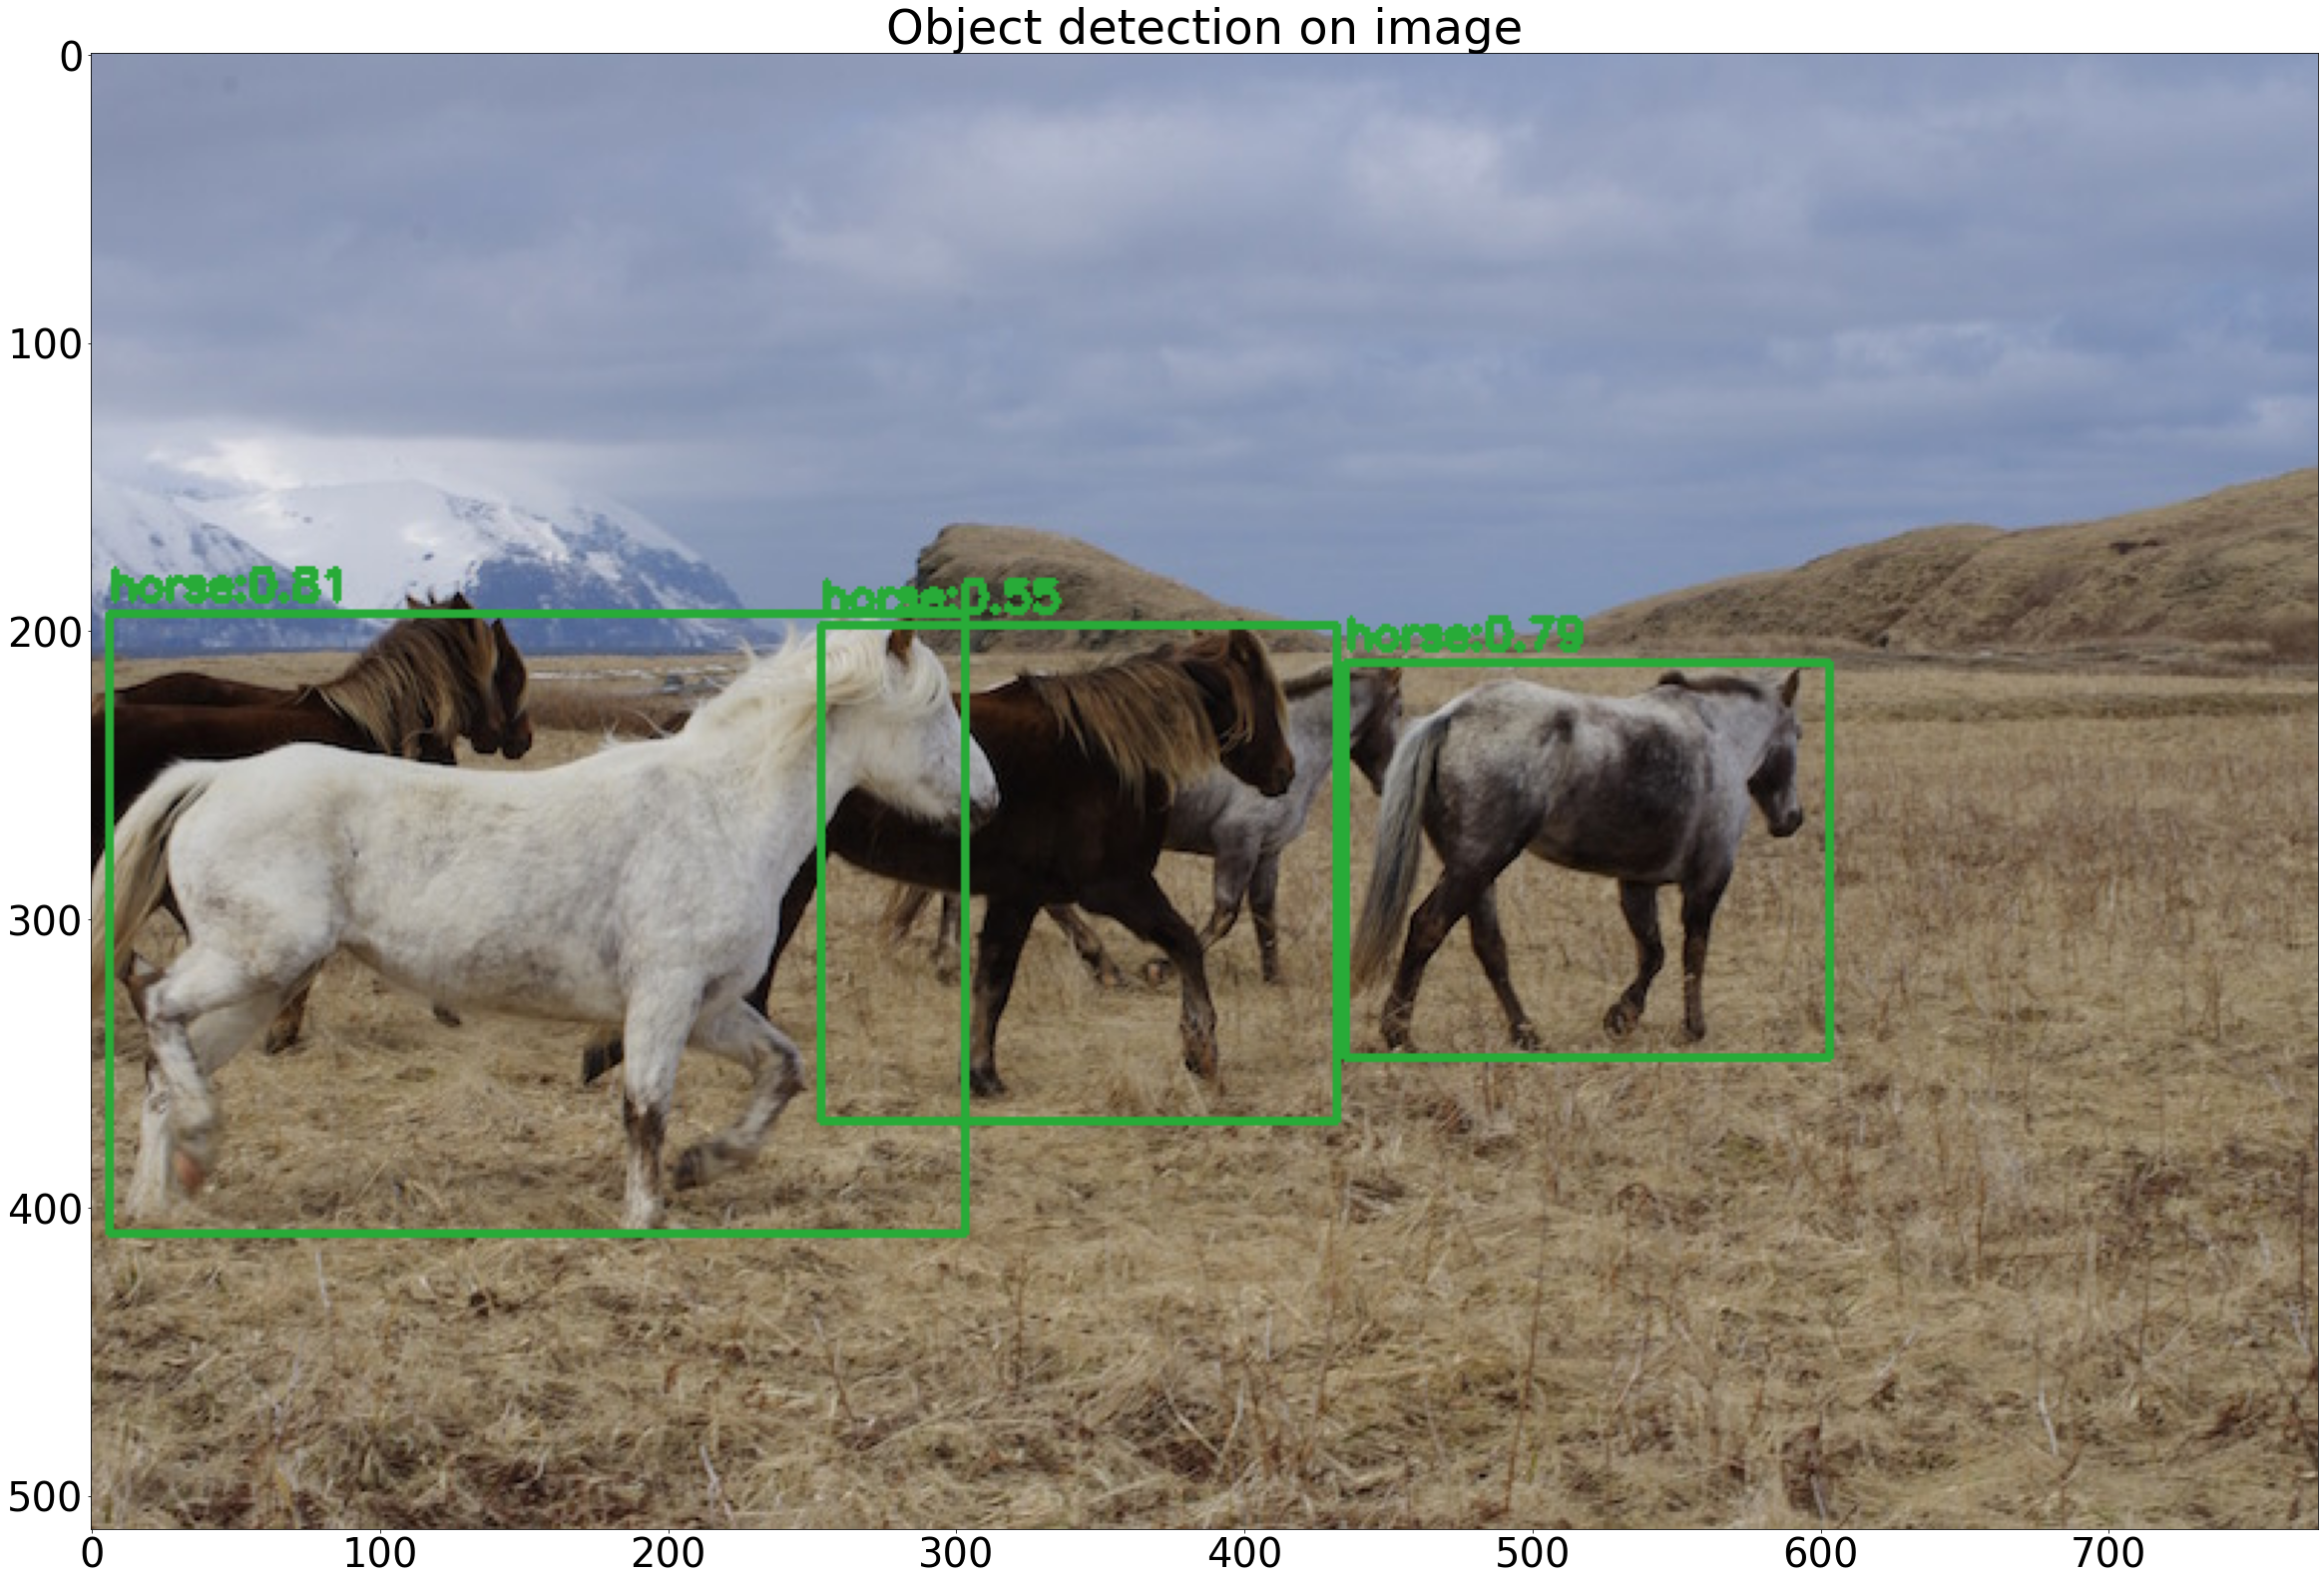

In [95]:
# Reading the input image 
image = cv2.imread(image_path)


# Height and Width of the image
H,W = image.shape[0:2]

# Scaling the image to the range (0,1) and resizing the image to size (608,608) for feeding to 
# CNN as yolo v2 CNN architecture accepts (608,608) sized image and encodes it to (19,19,5,85) dimension
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (608, 608), swapRB=True, crop=False)

# Set the resized and scaled image as input to the yolo network 
net.setInput(blob)

# Find the output of final layer of the CNN
output = net.forward(layer_names[-1])

# Initializing the list of bounding boxes which has the details of bounding box parameters 
# (i.e., centre coordinate, width and height of box)
boxes = []

# Initializing the list of confidence scores of each of the detected classes
confidences = []

# Initializing the list of class labels of each of the detected classes
class_ids = []

# Loop over each of the detected outputs   
for detection in output:
    # Extract the class ID and confidence scores of the each of the detected bounding boxes
    cls_scores = detection[5:]
    obj_det_prob = detection[4]
    class_id = np.argmax(cls_scores)
    confidence = cls_scores[class_id]*obj_det_prob

    # Filter out the weak predictions by eliminating the boxes with less confidence scores
    if confidence > confidence_th:
        # Since yolo returns the bounding box parameters in the range of (0,1), scale them back relative to 
        # the size of the original image. Here, the bounding box parameters are centre x-coordinate, 
        # centre y-coordinate, width and height of the image
        box = detection[0:4] * np.array([W, H, W, H])

        # Cast the scaled parameters to int data type as the pixel coordinates are of int data type
        (center_x, center_y, width, height) = box.astype("int")

        # Calculate the top-left corner of the image using the center coordinate (x,y) and width 
        # and height of the bounding box
        x = int(center_x - (width / 2))
        y = int(center_y - (height / 2))
        
        # Append the boxes, confidences and class IDs of the detections to our list of bounding box coordinates, 
        # confidences and class IDs
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        class_ids.append(class_id)

    # Apply non-maximum suppression and eliminate the boxes with based on their confidence scores and area of 
    # intersection over union between the bounding boxes and sort the indices based on their confidence scores
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, score_nms_th, iou_nms_th)

    # Loop over only if the list of box indices obtained after Non-maximal suppression is not empty
    if len(idxs) > 0:
        # Loop over the indexes we are keeping
        for i in idxs.flatten():
            # Extract the bounding box parameters (i.e., the top left corner, width and height of the bounding box)
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            # Draw a bounding box rectangle on the image
            color = [int(c) for c in colors[class_ids[i]]]

            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

            # Place the class label and class confidence score above the bounding box
            text = f'{labels[class_ids[i]]}:{confidences[i]:.2f}'
            #text = "{}: {:.4f}".format(labels[class_ids[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            
# Display the marked images
matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(40,30))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax.set_title('Object detection on image')

# Object detection on live video

Press the key 'q' when you want to stop the live object detection

In [96]:
# Object to capture the live video using the default camera of PC
cap = cv2.VideoCapture(0)


# Reading each frame of the live video and passing each of these frames as input to yolo v2 architecture in a loop 

while True:
    # Reading the frame of captured vide
    _,frame = cap.read()
    
    # Height and Width of the frame
    H,W = frame.shape[0:2]
    
    # Scaling the video frame to the range (0,1) and resizing the video frame to size (608,608) for feeding to 
    # CNN as yolo v2 CNN architecture accepts (608,608) sized image and encodes it to (19,19,5,85) dimension
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (608, 608), swapRB=True, crop=False)
    
    # Set the resized and scaled image as input to the yolo network 
    net.setInput(blob)

    # Find the output of final layer of the CNN
    output = net.forward(layer_names[-1])
    
    # Initializing the list of bounding boxes which has the details of bounding box parameters 
    # (i.e., centre coordinate, width and height of box)
    boxes = []
    
    # Initializing the list of confidence scores of each of the detected classes
    confidences = []
    
    # Initializing the list of class labels of each of the detected classes
    class_ids = []
    
    # Loop over each of the detected outputs   
    for detection in output:
        # Extract the class ID and confidence scores of the each of the detected bounding boxes
        cls_scores = detection[5:]
        obj_det_prob = detection[4]
        class_id = np.argmax(cls_scores)
        confidence = cls_scores[class_id]*obj_det_prob
        
        # Filter out the weak predictions by eliminating the boxes with less confidence scores
        if confidence > confidence_th:
            # Since yolo returns the bounding box parameters in the range of (0,1), scale them back relative to 
            # the size of the original image. Here, the bounding box parameters are centre x-coordinate, 
            # centre y-coordinate, width and height of the image
            box = detection[0:4] * np.array([W, H, W, H])
            
            # Cast the scaled parameters to int data type as the pixel coordinates are of int data type
            (center_x, center_y, width, height) = box.astype("int")
            
            # Calculate the top-left corner of the image using the center coordinate (x,y) and width 
            # and height of the bounding box
            x = int(center_x - (width / 2))
            y = int(center_y - (height / 2))
            
            # Append the boxes, confidences and class IDs of the detections to our list of bounding box coordinates, 
            # confidences and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)
        
        # Apply non-maximum suppression and eliminate the boxes based on their confidence scores and area of 
        # intersection over union between the bounding boxes and sort the indices based on their confidence scores
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, score_nms_th, iou_nms_th)
        
        # Loop over only if the list of box indices obtained after Non-maximal suppression is not empty
        if len(idxs) > 0:
            # Loop over the indexes we are keeping
            for i in idxs.flatten():
                # Extract the bounding box parameters (i.e., the top left corner, width and height of the bounding box)
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                # Draw a bounding box rectangle on the image
                color = [int(c) for c in colors[class_ids[i]]]

                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                
                # Place the class label and class confidence score above the bounding box
                text = f'{labels[class_ids[i]]}:{confidences[i]:.2f}'
                #text = "{}: {:.4f}".format(labels[class_ids[i]], confidences[i])
                cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                
    # Display the marked images with a duration of 1 ms 
    # Click on the camera window created by cv2
    cv2.imshow("Objects detection on live video", frame)
        
    # Press key q to stop the live detection and turn off the camera
    if ord("q") == cv2.waitKey(1):
        break

# Releases the I/O device (i.e.,camera) by opencv            
cap.release()

# Close all the opened windows
cv2.destroyAllWindows()